<a href="https://colab.research.google.com/github/andrewm4894/colabs/blob/master/PCA_Change_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import spatial

In [124]:
# input params
n_cols = 10
n_data = 2000
n_highlight = 500
baseline_start = 0
baseline_end = n_data - n_highlight
highlight_start = baseline_end + 1
highlight_end = n_data

# algo params
n_lag = 5
n_components = 1

# make data
df = pd.DataFrame(np.random.rand(n_data,n_cols), columns=[f'col_{n}' for n in range(1,n_cols+1)])

# smooth all data
df = df.rolling(15).mean().bfill()

# randomly sample for col_1 in highlight section
df[highlight_start:highlight_end]['col_1'] = np.random.rand((highlight_end-highlight_start))

# for col_2 lets just a max aggregation
df[highlight_start:highlight_end]['col_2'] = df[highlight_start:highlight_end]['col_2'].rolling(30).max().bfill()

# for col_3 lets smooth even more
df[highlight_start:highlight_end]['col_3'] = df[highlight_start:highlight_end]['col_3'].rolling(30).mean().bfill()

df_baseline = df[baseline_start:baseline_end]
df_highlight = df[highlight_start:]
print(df.shape)
print(df_baseline.shape)
print(df_highlight.shape)

(2000, 10)
(1500, 10)
(499, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

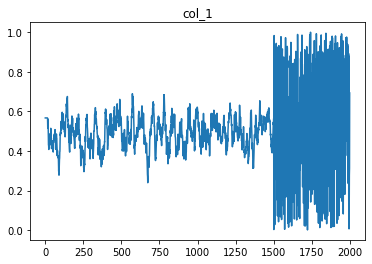

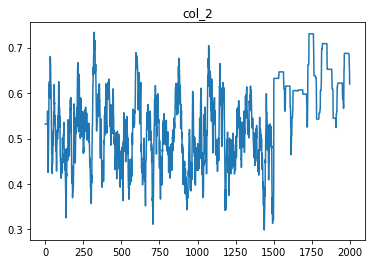

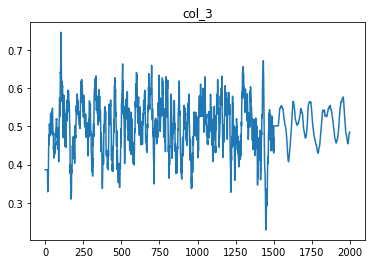

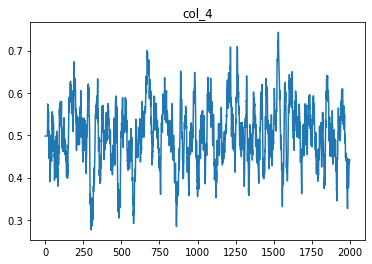

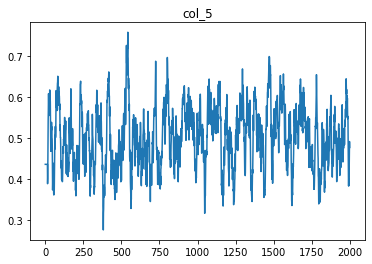

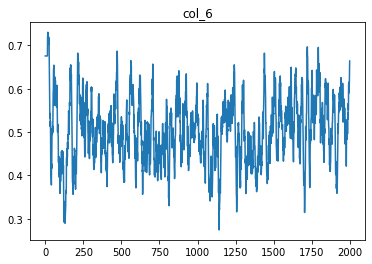

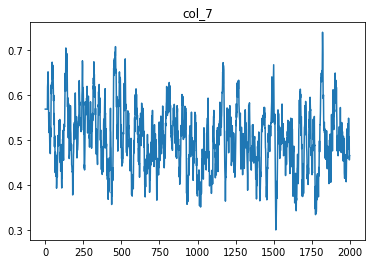

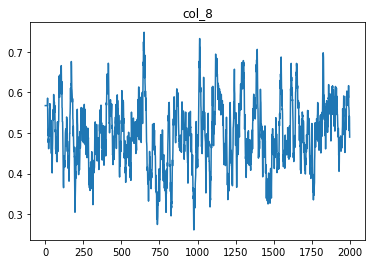

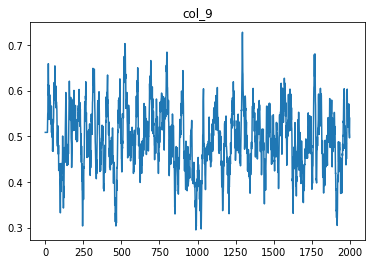

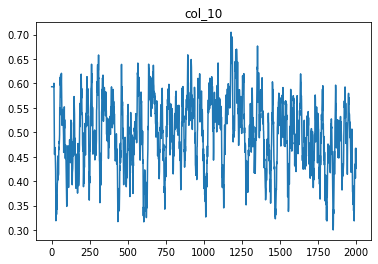

In [125]:
for col in df.columns:
    fig = df[col].plot(title=col)
    plt.show()

In [126]:
reconstruction_similarity = []

# loop over each metric
for col in df_highlight.columns:

    # preprocess baseline and highlight data
    # take differences
    # add lags
    X_baseline = pd.concat([df_baseline[col].diff().shift(n) for n in range(0, n_lag + 1)], axis=1).dropna().values
    X_highlight = pd.concat([df_highlight[col].diff().shift(n) for n in range(0, n_lag + 1)], axis=1).dropna().values

    # create pca
    pca = PCA(n_components=n_components)

    # fit pca based on preprocessed baseline data
    pca.fit(X_baseline)

    # use fitted pca to reconstruct the preprocessed highlight data
    X_highlight_reconstructed = pca.inverse_transform(pca.transform(X_highlight))

    # calculate the cosine similarity between the preprocessed highlight data and its reconstruction using the PCA fitted above.
    # metrics that have changed the most between the baseline and highlight window will have a lower quality reconstruction and so lower cosine similarity value
    cosine_similarity = 1 - spatial.distance.cosine(
        X_highlight_reconstructed.reshape(X_highlight_reconstructed.size),
        X_highlight.reshape(X_highlight.size)
    )
    reconstruction_similarity.append([col, cosine_similarity])

# sort to have lowest cosine similarity dims as those that look like they have changed the most.
df_reconstruction_similarity = pd.DataFrame(reconstruction_similarity, columns=['dim', 'cosine_similarity'])
df_reconstruction_similarity = df_reconstruction_similarity.sort_values('cosine_similarity', ascending=True)
df_reconstruction_similarity = df_reconstruction_similarity.set_index('dim')

# look at data
# lower cosine_similarity are those that have changed the most
df_reconstruction_similarity

,cosine_similarity
dim,
col_3,0.138601
col_1,0.264772
col_2,0.316359
col_10,0.381890
col_9,0.399939
col_7,0.400711
col_4,0.402699
col_5,0.412232
col_8,0.415525
